In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
def pb():
    return torch.distributions.MultivariateNormal(
        torch.tensor([0.0,0.0]),
        torch.tensor([[1.0,-0.5],[-0.5,1.0]]))

In [4]:
def ps():
    return torch.distributions.MultivariateNormal(
        torch.tensor([1.0,1.0]),
        torch.tensor([[1.0,0.0],[0.0,1.0]]))

In [5]:
def linear_init(*args, **kwargs):
    linear = nn.Linear(*args, **kwargs)
    linear.weight.data.normal_(0.0, np.sqrt(1/linear.in_features))
    return linear

In [6]:
def linear_selu(*args, **kwargs):
    return nn.Sequential(linear_init(*args, **kwargs), nn.SELU())

In [7]:
def full(n, hid, **kwargs):
    layers = [linear_selu(hid, hid) for _ in range(n)]
    return nn.Sequential(*layers)

In [8]:
class Predictor(nn.Module):
    def __init__(self, *args, inputs=1, outputs=1, layers=2, hid=20, **kwargs):
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
                linear_selu(inputs, hid),
                full(layers, hid, bias=False),
                linear_init(hid, outputs))
    def forward(self, x):
        return self.layers(x)

In [9]:
class GaussianMixture(nn.Module):
    def __init__(self, inputs, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.unflatten = nn.Unflatten(-1, (inputs, 3))
    def forward(self, x, z):
        # p(z;x)
        guess = self.unflatten(x)
        mu = guess[...,0]
        sigma = torch.exp(guess[...,1])
        log_pi = F.log_softmax(guess[...,2],dim=-1)
        d = torch.distributions.Normal(mu, sigma)
        prob = torch.sum(torch.exp(d.log_prob(z) + log_pi), dim=-1)
        return prob

In [10]:
class Adversary(nn.Module):
    def __init__(self, *args, inputs=1, outs=5, layers=2, hid=20, **kwargs):
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            linear_selu(inputs, hid, bias=False),
            full(layers, hid, bias=False),
            linear_init(hid, outs*3))
        self.mix = GaussianMixture(outs)
    def forward(self, s, z):
        r = self.layers(s)
        return self.mix(r, z)

In [11]:
def batch(size, z=None):
    y = torch.distributions.Bernoulli(0.5).sample([size,1])
    if z is None:
        z = torch.distributions.Normal(0, 1).sample([size,1])
    else:
        z = torch.ones(size, 1)*float(z)
    x0 = pb().sample([size])
    x1 = ps().sample([size]) + torch.nn.functional.pad(z, (1,0))
    x = torch.where(y.bool(), x1, x0)
    return x, y, z

In [12]:
def train_x_y(epochs, batch_size, device):
    predictor = Predictor(inputs=2).to(device)
    params = predictor.parameters()
    optimizer = torch.optim.Adam(params)
    for epoch in range(epochs):
        x, y, z = batch(batch_size)
        prediction = predictor(x.to(device))
        loss = F.binary_cross_entropy_with_logits(prediction, y.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return predictor

In [13]:
def train_adv_x_y(pre_epochs, epochs, adv_epochs, batch_size, device, predictor):
    predictor = predictor.to(device)
    adversary = Adversary().to(device)
    optimizer_pred = torch.optim.Adam(predictor.parameters())
    optimizer_adv = torch.optim.Adam(adversary.parameters())
    adversary.train()
    for epoch in range(-pre_epochs, epochs):
        predictor.eval()
        for adv_epoch in range(adv_epochs):
            x, y, z = batch(batch_size)
            with torch.set_grad_enabled(False):
                prediction = predictor(x.to(device))
            prob = adversary(prediction, z.to(device))
            loss = -torch.mean(torch.log(prob+1e-10))
            optimizer_adv.zero_grad()
            loss.backward()
            optimizer_adv.step()
        if epoch >= 0:
            predictor.train()
            x, y, z = batch(batch_size)
            prediction = predictor(x.to(device))            
            prob = adversary(prediction, z.to(device))
            loss_f = F.binary_cross_entropy_with_logits(prediction, y.to(device))
            loss_r = -torch.mean(torch.log(prob+1e-10))
            loss = loss_f - 50 * loss_r
            optimizer_pred.zero_grad()
            loss.backward()
            optimizer_pred.step()
            print(epoch, loss.item(), loss_f.item(), loss_r.item())
    return predictor, adversary

In [14]:
def nn_to_f(pred):
    def f(x):
        return torch.sigmoid(pred(torch.as_tensor(x, dtype=torch.float))).detach().numpy()[:,0]
    return f

# Plotting

In [15]:
def scatter(f):
    X_test = np.random.rand(30000, 2)
    X_test[:, 0] *= 10.
    X_test[:, 0] -= 5.
    X_test[:, 1] *= 10.
    X_test[:, 1] -= 5.
    y_pred = f(X_test).ravel()
    xi = np.linspace(-1., 2., 100)
    yi = np.linspace(-1., 3, 100)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis,
                      vmax=1.0, vmin=0.0)
    plt.colorbar()
    plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
    plt.scatter([1], [0], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
    plt.scatter([1], [0+1], c="blue", linewidths=0)
    plt.scatter([1], [0+2], c="blue", linewidths=0)
    plt.text(1.2, 0-0.1, "$Z=-\sigma$", color="k")
    plt.text(1.2, 1-0.1, "$Z=0$", color="k")
    plt.text(1.2, 2-0.1, "$Z=+\sigma$", color="k")
    plt.xlim(-1,2)
    plt.ylim(-1,3)
    plt.legend(loc="upper left", scatterpoints=1)
    plt.gca().set_aspect('equal')
    plt.show()

In [16]:
def plot_hist(axes, X, y, f):
    pred = f(X)
    pred0 = pred[y[:,0]==0]
    pred1 = pred[y[:,0]==1]
    axes.hist(pred, bins=np.linspace(0,1,51), density=True, histtype="step", label="$p(f(X))$")
    axes.hist(pred0, bins=np.linspace(0,1,51), density=True, histtype="step", label="$p(f(X|y=0))$")
    axes.hist(pred1, bins=np.linspace(0,1,51), density=True, histtype="step", label="$p(f(X|y=1))$")
    axes.set_ylim(0,4)
    axes.set_xlabel("$f(X...)$")
    axes.set_ylabel("$p(f(X...))$")
    axes.grid()
    axes.legend()

In [17]:
def plot_hists(axes, X0, X1, X_1, f):
    axes.hist(f(X1), bins=np.linspace(0,1,51), histtype='step', density=True, label="p(f(X|z=1))")
    axes.hist(f(X0), bins=np.linspace(0,1,51), histtype='step', density=True, label="p(f(X|z=0))")
    axes.hist(f(X_1), bins=np.linspace(0,1,51), histtype='step', density=True, label="p(f(X|z=-1))")
    axes.set_xlabel("$f(X|Z)$")
    axes.set_ylabel("$p(f(X|Z))$")
    plt.grid()
    axes.legend()

In [18]:
def plot_data(axes, X, y, title="$X$"):
    axes.set_title(title)
    axes.scatter(X[y[:,0]==0, 0], X[y[:,0]==0, 1], c="r", marker=".", edgecolors="none")
    axes.scatter(X[y[:,0]==1, 0], X[y[:,0]==1, 1], c="b", marker=".", edgecolors="none")
    axes.set_xlim(-4, 4)
    axes.set_ylim(-4, 4)
    axes.set_aspect('equal')

# Main

In [19]:
X, y, z = batch(10000)
X0, y0, z0 = batch(10000, 0)
X1, y1, z1 = batch(10000, 1)
X_1, y_1, z_1 = batch(10000, -1)

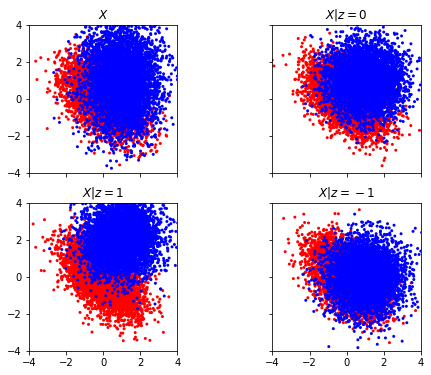

In [20]:
fig, ax = plt.subplots(2,2,figsize=(8,6), sharex=True, sharey=True)
plot_data(ax[0,0], X, y, "$X$")
plot_data(ax[0,1], X0, y0, "$X|z=0$")
plot_data(ax[1,0], X1, y1, "$X|z=1$")
plot_data(ax[1,1], X_1, y_1, "$X|z=-1$")
plt.show()

In [21]:
pred_x_y = train_x_y(100, 10000, "cpu").to("cpu").eval()

In [22]:
f_x_y = nn_to_f(pred_x_y)

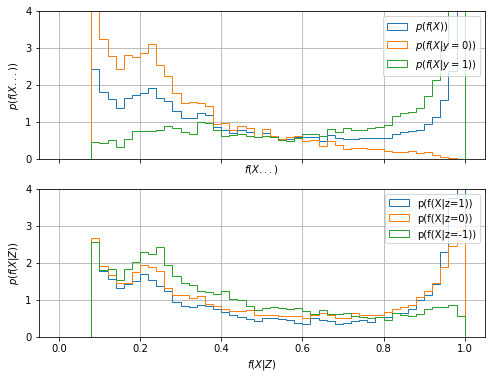

In [23]:
fig, ax = plt.subplots(2,1,figsize=(8,6), sharex=True, sharey=True)
plot_hist(ax[0], X, y, f_x_y)
plot_hists(ax[1], X0, X1, X_1, f_x_y)
plt.show()

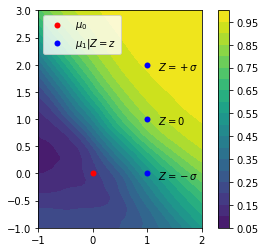

In [24]:
scatter(f_x_y)

In [25]:
pa_x_y, adv_x_y = train_adv_x_y(50, 200, 500, 128, "cpu", pred_x_y)

0 -61.364383697509766 0.5054579377174377 1.2373968362808228
1 -72.10226440429688 0.4707708954811096 1.4514607191085815
2 -68.78477478027344 0.3707791566848755 1.3831111192703247
3 -66.72567749023438 0.4471810460090637 1.3434572219848633
4 -64.35126495361328 0.43750518560409546 1.2957754135131836
5 -65.6549301147461 0.4376138746738434 1.3218508958816528
6 -68.228271484375 0.4136813282966614 1.3728389739990234
7 -65.76545715332031 0.4053957760334015 1.323417067527771
8 -67.32908630371094 0.4632071852684021 1.3558458089828491
9 -68.8929672241211 0.5037765502929688 1.3879348039627075
10 -69.38677978515625 0.44106507301330566 1.3965568542480469
11 -66.68836975097656 0.5980722904205322 1.345728874206543
12 -74.24153137207031 0.539817214012146 1.4956269264221191
13 -77.2496337890625 0.5112934112548828 1.5552184581756592
14 -71.38960266113281 0.47111907601356506 1.4372144937515259
15 -73.75871276855469 0.47403085231781006 1.4846547842025757
16 -65.54833221435547 0.6884748935699463 1.3247362375

139 -73.54634857177734 0.6328079104423523 1.4835830926895142
140 -67.96752166748047 0.6043916940689087 1.3714382648468018
141 -68.03165435791016 0.5425726175308228 1.3714845180511475
142 -73.39448547363281 0.6122381687164307 1.4801344871520996
143 -66.7968978881836 0.6109076738357544 1.3481560945510864
144 -69.28329467773438 0.6203584671020508 1.3980731964111328
145 -71.19306945800781 0.5977738499641418 1.435816764831543
146 -67.21131134033203 0.5693327784538269 1.3556129932403564
147 -72.90972900390625 0.5777297019958496 1.4697492122650146
148 -69.0478744506836 0.5800651907920837 1.3925586938858032
149 -69.655029296875 0.5332972407341003 1.4037665128707886
150 -70.33210754394531 0.5557354688644409 1.4177567958831787
151 -72.5577163696289 0.569442868232727 1.462543249130249
152 -70.93145751953125 0.5506458282470703 1.4296419620513916
153 -69.74105072021484 0.613248348236084 1.4070860147476196
154 -72.22257232666016 0.6025570631027222 1.4565025568008423
155 -72.6970443725586 0.583783090

In [26]:
fa_x_y = nn_to_f(pa_x_y)

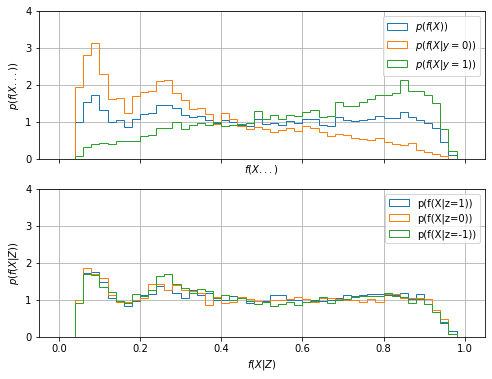

In [27]:
fig, ax = plt.subplots(2,1,figsize=(8,6), sharex=True, sharey=True)
plot_hist(ax[0], X, y, fa_x_y)
plot_hists(ax[1], X0, X1, X_1, fa_x_y)
plt.show()

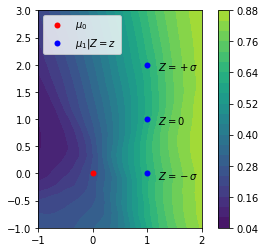

In [28]:
scatter(fa_x_y)